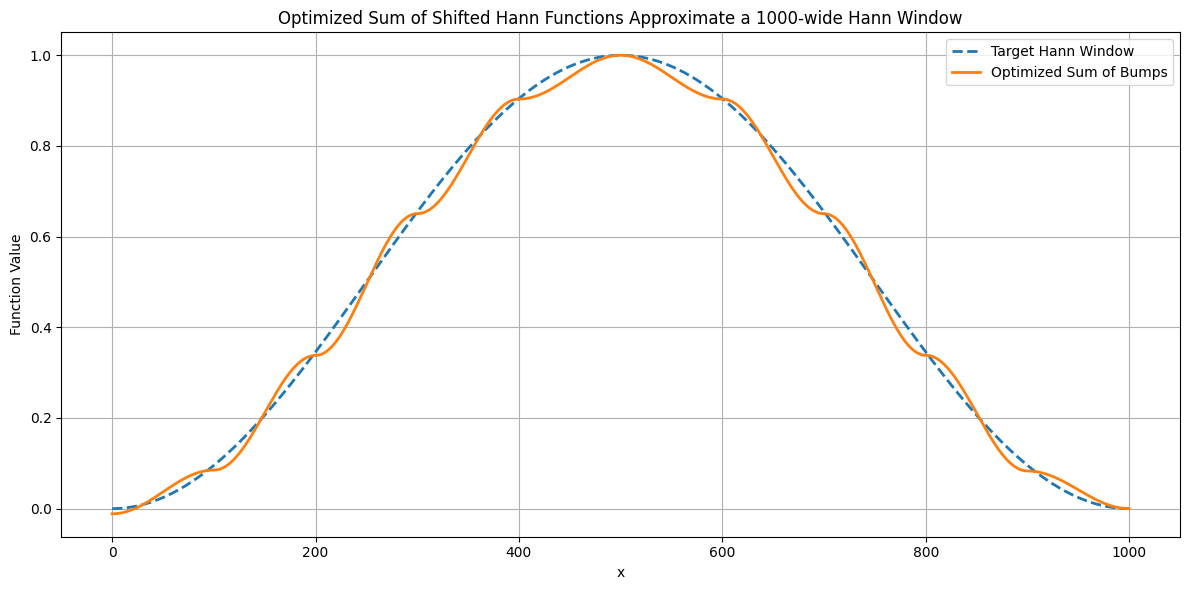

Optimized coefficients:
 [-0.01150096  0.08602739  0.34189202  0.65811195  0.91394513  1.01166201
  0.91395481  0.65805391  0.34223057  0.08405413]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.interpolate import BSpline, make_interp_spline

# Define Gaussian function
def gaussian_bump(x, center, width):
    return np.exp(-0.5 * ((x - center) / width) ** 2)

# Define B-Spline function
def bspline_bump(x, center, width):
    knots = np.linspace(center - width, center + width, 4)  # 3 degree B-spline
    coefs = [1, 4, 6, 4, 1]  # Uniform coefficients for a smooth spline
    spline = BSpline(knots, coefs, 3, extrapolate=False)
    return spline(x)

# Define Cosine bump function
def cosine_bump(x, center, width):
    t = (x - center) / width
    return np.cos(np.pi * t) * (np.abs(t) <= 1)

# Setup parameters
window_size = 1000  # Full window size
bump_size = 100     # Width of each bump
overlap_size = 50   # Overlap between bumps
num_bumps = window_size // bump_size  # Number of bumps (10 for 1000 width, with 100 per bump)

# Create centers for the bumps, placing them with overlap
centers = np.linspace(0, window_size - bump_size, num_bumps)

# Define x grid for plotting
x = np.linspace(0, window_size, 1000)

# Create the target 100-wide Hann window for comparison
target_hann = 0.5 * (1 + np.cos(np.pi * (x - window_size // 2) / (window_size // 2)))

# Define a function for the sum of the bumps with coefficients
def sum_bumps_with_coeffs(coeffs, bumps):
    return sum(c * b for c, b in zip(coeffs, bumps))

# Define objective function for least-squares optimization
def objective(coeffs, bumps, target):
    approx = sum_bumps_with_coeffs(coeffs, bumps)
    return approx - target

# Function to perform the least-squares optimization for different basis functions
def optimize_basis_function(bump_func, centers, bump_size, target_hann):
    bumps = [bump_func(x, center, bump_size) for center in centers]
    initial_guess = np.ones(len(centers))  # Initial guess for coefficients
    result = least_squares(objective, initial_guess, args=(bumps, target_hann))
    optimized_coeffs = result.x
    optimized_sum = sum_bumps_with_coeffs(optimized_coeffs, bumps)
    return optimized_coeffs, optimized_sum

# Optimize using different basis functions
coeffs_gaussian, sum_gaussian = optimize_basis_function(gaussian_bump, centers, bump_size, target_hann)
coeffs_bspline, sum_bspline = optimize_basis_function(bspline_bump, centers, bump_size, target_hann)
coeffs_cosine, sum_cosine = optimize_basis_function(cosine_bump, centers, bump_size, target_hann)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the target Hann window
plt.plot(x, target_hann / np.max(target_hann), label="Target 100-wide Hann Window", linestyle='--', linewidth=2)

# Plot the approximations with different basis functions
plt.plot(x, sum_gaussian / np.max(sum_gaussian), label="Gaussian Approximation", linewidth=2)
plt.plot(x, sum_bspline / np.max(sum_bspline), label="B-Spline Approximation", linewidth=2)
plt.plot(x, sum_cosine / np.max(sum_cosine), label="Cosine Approximation", linewidth=2)

plt.title("Different Basis Functions Approximating a 100-wide Hann Window")
plt.xlabel('x')
plt.ylabel('Function Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
